In [1]:
# import fs
from fsspec import url_to_fs

filepath = '.'
fs, _ = url_to_fs(filepath)

# Open the file with read permissions
try:
    with fs.open(filepath, "x") as f:
        file_content = f.read()
        print(f"File content: {file_content}")
except PermissionError:
    print(f"Permission denied when trying to access {filepath}.")
except Exception as e:
    print(f"An error occurred while accessing {filepath}: {e}")

Permission denied when trying to access ..


In [8]:
from pathlib import Path

filepath = Path('./*.txt')  # Use Path object to represent the file path

try:
    with filepath.open('rb') as f:  # Open the file in read-binary mode
        file_content = f.read()
        print(f"File content: {file_content}")
except PermissionError:
    print(f"Permission denied when trying to access {filepath}.")
except Exception as e:
    print(f"An error occurred while accessing {filepath}: {e}")

An error occurred while accessing *.txt: [Errno 22] Invalid argument: '*.txt'


In [9]:
# read csv with pandas
import pandas as pd

data_path = '../data_input/train.csv'
df = pd.read_csv(data_path, usecols=['id', 'text', 'label'])
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 157789 entries, 0 to 157788
Data columns (total 3 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   id      157789 non-null  object
 1   text    157789 non-null  object
 2   label   157789 non-null  int64 
dtypes: int64(1), object(2)
memory usage: 3.6+ MB


In [ ]:
emb_dim = 16
context_length = 30

In [2]:
vocab = set(df['text'].str.cat(sep=' ').split())
len(vocab)

5000

In [3]:
vocab = sorted(list(vocab))

In [4]:
stoi = {s:i+1 for i,s in enumerate(vocab)}
stoi['.'] = 0
itos = {i:s for s,i in stoi.items()}

In [5]:
len(stoi)

5001

In [6]:
import torch

In [7]:
# make X from df['text'] with vtoi
X = df['text'].apply(lambda x: [stoi[v] for v in x.split()])

In [8]:
X[0]

[2516,
 2927,
 1155,
 2516,
 880,
 3663,
 1025,
 3113,
 1652,
 3663,
 3652,
 2927,
 2943,
 2186]

In [9]:
X = X.apply(lambda x: [0]*(context_length-len(x)) + list(x) if len(x) < context_length  else x[:context_length])

In [10]:
# get pandas item from X
X = torch.tensor(X)

In [11]:
X[0]

tensor([   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0, 2516, 2927, 1155, 2516,  880, 3663, 1025, 3113,
        1652, 3663, 3652, 2927, 2943, 2186])

In [12]:
# one hot encode X row element with vocab size
torch.nn.functional.one_hot(X[0], num_classes=len(stoi)).float()

tensor([[1., 0., 0.,  ..., 0., 0., 0.],
        [1., 0., 0.,  ..., 0., 0., 0.],
        [1., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])

In [14]:
# split X and Y into train and val, stratify by Y
from sklearn.model_selection import train_test_split

X_train, X_val, Y_train, Y_val = train_test_split(X, Y, test_size=0.2, stratify=Y)

In [15]:
X_train.shape, X_val.shape

(torch.Size([126231, 30]), torch.Size([31558, 30]))

In [17]:
g = torch.Generator().manual_seed(2147483647) # for reproducibility
C = torch.randn((len(stoi), emb_dim), generator=g)

In [18]:
C.shape

torch.Size([5001, 3])

In [19]:
X_train[range(4)].shape

torch.Size([4, 30])

In [20]:
emb = C[X_train[range(4)]] # (32, 3, 10)
emb.shape

torch.Size([4, 30, 3])

In [21]:
len(vocab)

5000

In [22]:
C = torch.randn((len(stoi), emb_dim), generator=g)
C[0]

tensor([1.1198, 2.0405, 0.3195])

In [118]:
# forward pass
import torch.nn as nn
import torch.nn.functional as F

class Linear(nn.Linear):
    def __init__(self, in_features, out_features, bias=True):
        super(Linear, self).__init__(in_features, out_features, bias)
        self.out = None
        
    def forward(self, x):
        self.out = super().forward(x)
        return self.out

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        g = torch.Generator().manual_seed(2147483647) # for reproducibility
        C = torch.randn((len(stoi), emb_dim), generator=g)
        # normalize C by root of emb_dim
        C /= (context_length * emb_dim) ** 0.5
        # self.C.requires_grad = True
        # set C to be parameters
        self.register_parameter('C', nn.Parameter(C))
        self.fc1 = Linear(context_length * emb_dim, 100, bias=False)
        self.bn1 = nn.BatchNorm1d(100)
        self.act1 = nn.Tanh()
        self.fc2 = Linear(100, 20, bias=False)
        self.fc2.weight = nn.Parameter(self.fc2.weight * 5/3, requires_grad=True)
        self.bn2 = nn.BatchNorm1d(20)
        self.act2 = nn.Tanh()
        self.fc3 = Linear(20, 5)
        # change fc3 weights by gain
        self.fc3.weight = nn.Parameter(self.fc3.weight * 0.1, requires_grad=True)
        
        
    def forward(self, x):
        emb = self.C[x]
        self.fc1.out = self.fc1(emb.view(-1, 30 * emb_dim))
        self.bn1.out = self.bn1(self.fc1.out)
        self.act1.out = self.act1(self.bn1.out)
        
        self.fc2.out = self.fc2(self.act1.out)
        self.bn2.out = self.bn2(self.fc2.out)
        self.act2.out = self.act2(self.bn2.out)
        
        self.fc3.out = self.fc3(self.act2.out)
        return self.fc3.out
    
    def get_layers(self):
        layers = []
        for module in self.modules():
            if isinstance(module, nn.Linear) or isinstance(module, nn.BatchNorm1d) or isinstance(module, nn.Tanh):
                layers.append(module)
        return layers
    
    def get_parameters(self):
        parameters = [self.C]
        for module in self.modules():
            if isinstance(module, nn.Linear) or isinstance(module, nn.BatchNorm1d):
                parameters.append(module.weight)
                if module.bias is not None:
                    parameters.append(module.bias)
        return parameters

In [119]:
l.weight = nn.Parameter(l.weight * 5/3)


In [120]:
import torch.optim as optim

net = Net()
criterion = nn.CrossEntropyLoss()

In [121]:
optimizer = optim.AdamW(net.parameters(), lr=0.0001)

In [122]:
sum([ p.nelement() for p in net.parameters()])

26348

In [123]:
layers = net.get_layers()

In [180]:
# same optimization as last time
max_steps = 50000
batch_size = 32
ud = []
lossi = []

# train
for i in range(max_steps):
    # train with batches and consider the last batch
    batch_size = 32
    # minibatch construct
    ix = torch.randint(0, X_train.shape[0], (batch_size,))

    outputs = net(X_train[ix])
    loss = criterion(outputs, Y_train[ix])
    
    # backward pass
    for layer in layers:
      layer.out.retain_grad() # AFTER_DEBUG: would take out retain_graph
    for p in net.parameters():
      p.grad = None
      
    loss.backward()
    
    # update
    lr = 0.01 if i < 150000 else 0.01 # step learning rate decay
    for p in net.parameters():
      p.data += -lr * p.grad

    # track stats
    if i % 1000 == 0: # print every once in a while
      print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
    lossi.append(loss.log10().item())
    with torch.no_grad():
      ud.append([((lr*p.grad).std() / p.data.std()).log10().item() for p in net.parameters()])

    if i >= 10000:
      pass #break # AFTER_DEBUG: would take out obviously to run full optimization

      0/  50000: 0.8779
   1000/  50000: 1.0845
   2000/  50000: 0.8707
   3000/  50000: 1.0112
   4000/  50000: 1.0847
   5000/  50000: 1.1233
   6000/  50000: 0.9734
   7000/  50000: 1.0767
   8000/  50000: 1.0774
   9000/  50000: 1.2450
  10000/  50000: 0.8252
  11000/  50000: 1.1549
  12000/  50000: 1.1848
  13000/  50000: 0.9296
  14000/  50000: 1.0101
  15000/  50000: 0.9477
  16000/  50000: 0.9236
  17000/  50000: 0.9839
  18000/  50000: 0.9913
  19000/  50000: 1.0392
  20000/  50000: 1.0429
  21000/  50000: 1.1250
  22000/  50000: 1.1556
  23000/  50000: 1.1930
  24000/  50000: 0.9884
  25000/  50000: 0.9165
  26000/  50000: 0.9380
  27000/  50000: 0.9528
  28000/  50000: 0.9046
  29000/  50000: 0.9843
  30000/  50000: 0.9959
  31000/  50000: 1.0023
  32000/  50000: 0.8544
  33000/  50000: 1.0578
  34000/  50000: 0.8466
  35000/  50000: 1.1838
  36000/  50000: 1.2034
  37000/  50000: 0.8297
  38000/  50000: 0.8840
  39000/  50000: 1.1093
  40000/  50000: 1.0218
  41000/  50000:

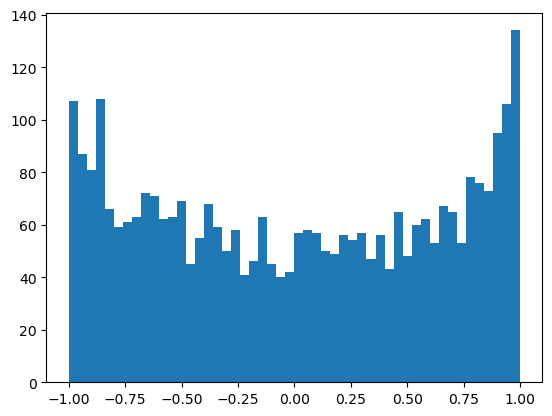

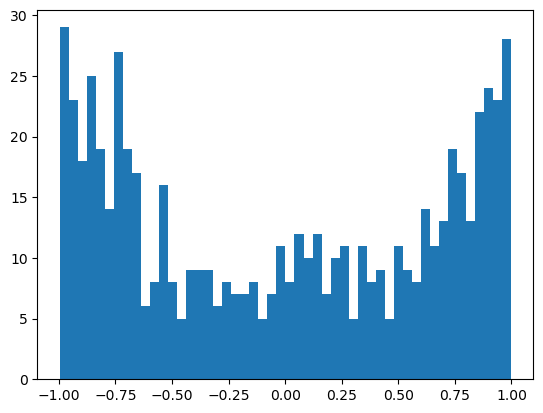

In [181]:
import matplotlib.pyplot as plt
tanh1 = net.act1.out
plt.hist(tanh1.view(-1).tolist(), bins=50);
plt.show()
plt.hist(net.act2.out.view(-1).tolist(), bins=50);

layer 2 (Tanh): mean +0.01, std 0.64, saturated: 5.50%
layer 5 (Tanh): mean -0.01, std 0.68, saturated: 6.56%


Text(0.5, 1.0, 'activation distribution')

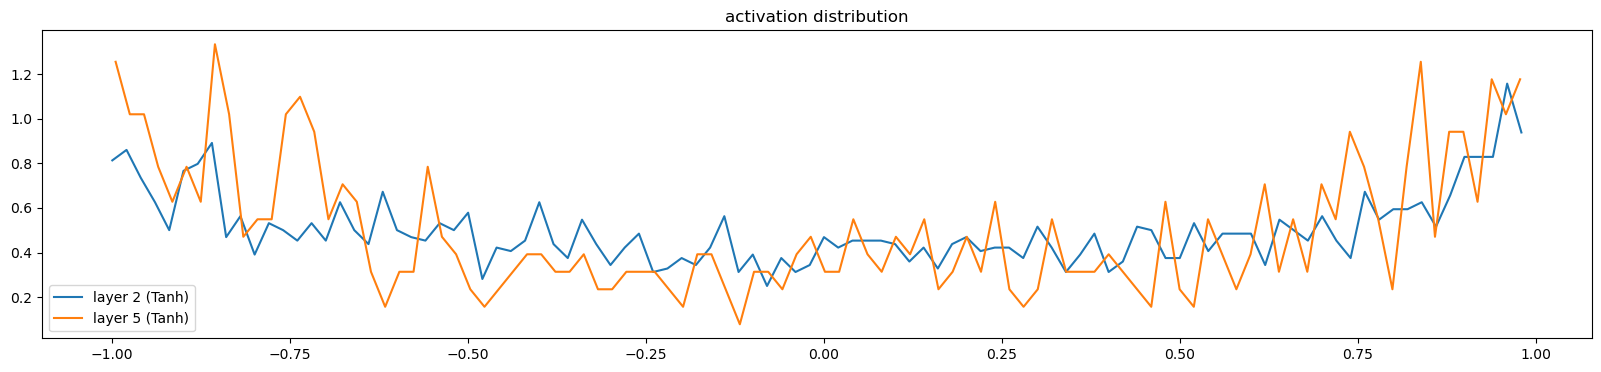

In [182]:
import matplotlib.pyplot as plt

# visualize histograms
plt.figure(figsize=(20, 4)) # width and height of the plot
legends = []
for i, layer in enumerate(net.get_layers()[:-1]): # note: exclude the output layer
  if isinstance(layer, nn.Tanh):
    t = layer.out
    print('layer %d (%s): mean %+.2f, std %.2f, saturated: %.2f%%' % (i, layer.__class__.__name__, t.mean(), t.std(), (t.abs() > 0.97).float().mean()*100))
    hy, hx = torch.histogram(t, density=True)
    plt.plot(hx[:-1].detach(), hy.detach())
    legends.append(f'layer {i} ({layer.__class__.__name__})')
plt.legend(legends);
plt.title('activation distribution')

layer 2 (      Tanh): mean +0.000000, std 3.926050e-03
layer 5 (      Tanh): mean -0.000022, std 7.470992e-03


Text(0.5, 1.0, 'gradient distribution')

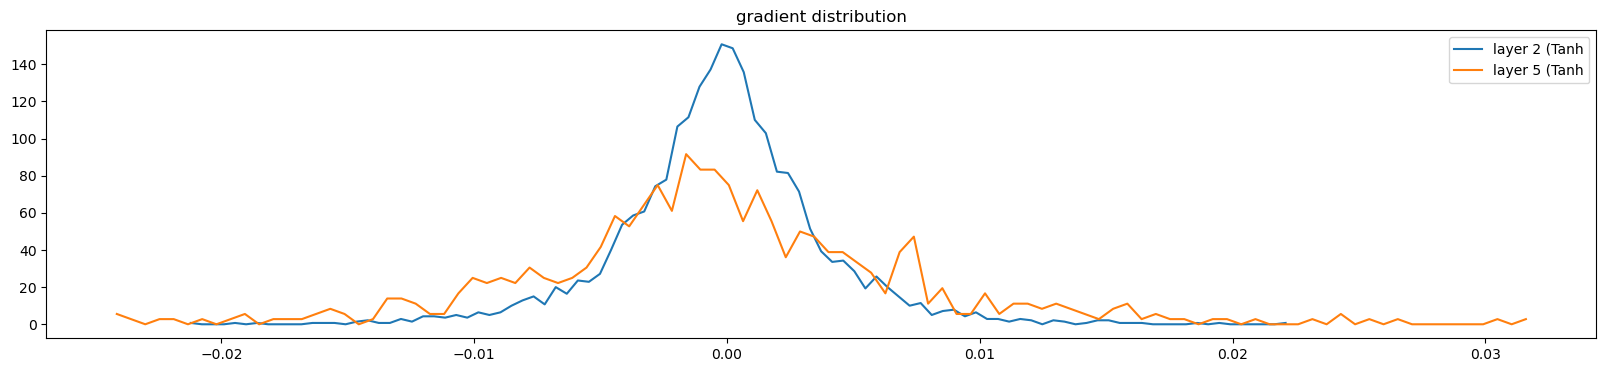

In [183]:
# visualize histograms
plt.figure(figsize=(20, 4)) # width and height of the plot
legends = []
for i, layer in enumerate(net.get_layers()[:-1]): # note: exclude the output layer
  if isinstance(layer, nn.Tanh):
    t = layer.out.grad
    print('layer %d (%10s): mean %+f, std %e' % (i, layer.__class__.__name__, t.mean(), t.std()))
    hy, hx = torch.histogram(t, density=True)
    plt.plot(hx[:-1].detach(), hy.detach())
    legends.append(f'layer {i} ({layer.__class__.__name__}')
plt.legend(legends);
plt.title('gradient distribution')

weight  (5001, 3) | mean +0.000000 | std 1.783515e-02 | grad:data ratio 1.585246e-01
weight  (100, 90) | mean -0.000636 | std 1.843420e-02 | grad:data ratio 2.344048e-01
weight  (20, 100) | mean +0.000493 | std 1.934941e-02 | grad:data ratio 1.724019e-01
weight    (5, 20) | mean +0.000000 | std 3.767585e-02 | grad:data ratio 1.072959e-01


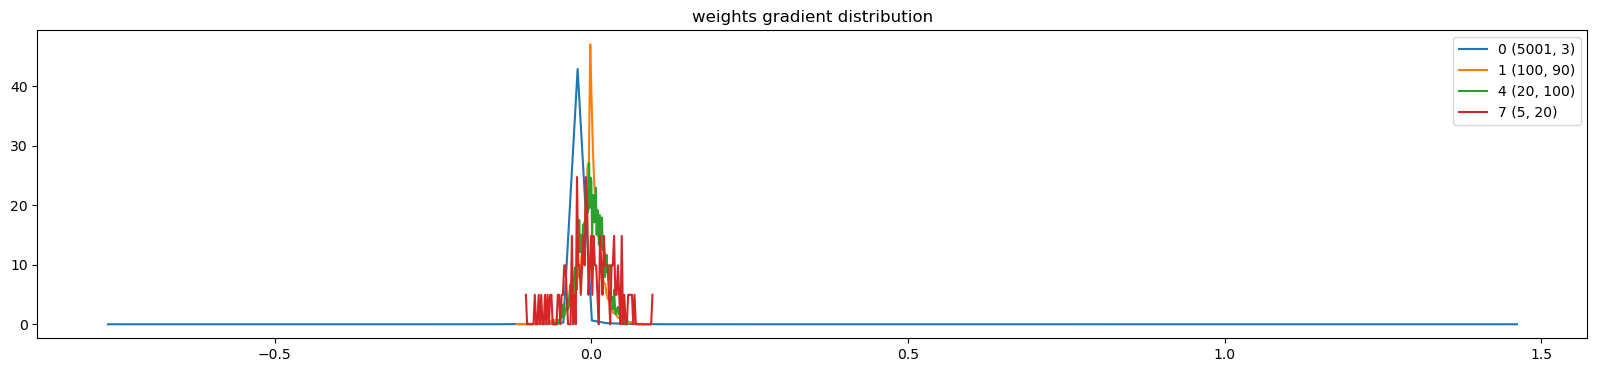

In [184]:
# visualize histograms
plt.figure(figsize=(20, 4)) # width and height of the plot
legends = []
for i,p in enumerate(net.parameters()):
  t = p.grad
  if p.ndim == 2:
    print('weight %10s | mean %+f | std %e | grad:data ratio %e' % (tuple(p.shape), t.mean(), t.std(), t.std() / p.std()))
    hy, hx = torch.histogram(t, density=True)
    plt.plot(hx[:-1].detach(), hy.detach())
    legends.append(f'{i} {tuple(p.shape)}')
plt.legend(legends)
plt.title('weights gradient distribution');

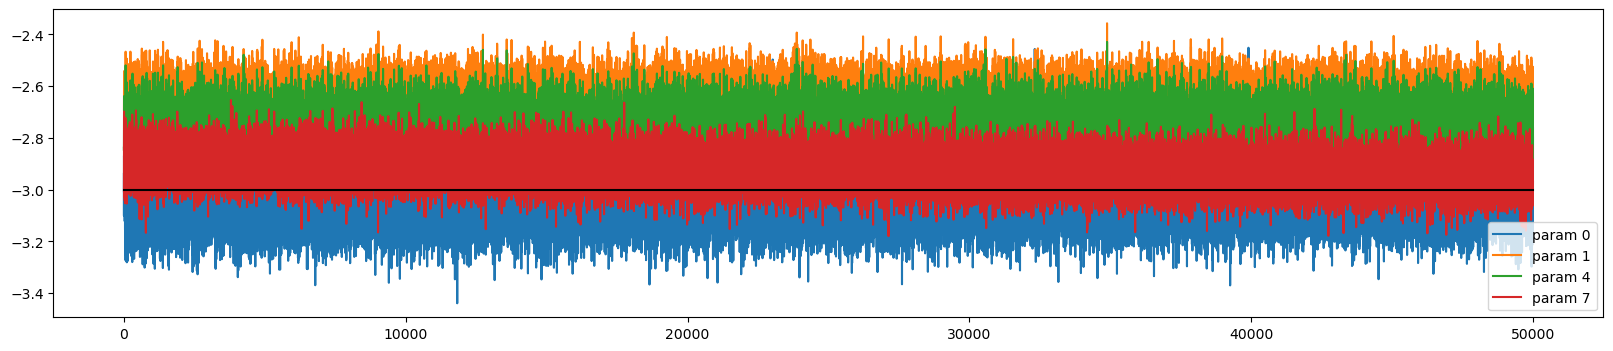

In [185]:
plt.figure(figsize=(20, 4))
legends = []
for i,p in enumerate(net.parameters()):
  if p.ndim == 2:
    plt.plot([ud[j][i] for j in range(len(ud))])
    legends.append('param %d' % i)
plt.plot([0, len(ud)], [-3, -3], 'k') # these ratios should be ~1e-3, indicate on plot
plt.legend(legends);

In [186]:
outputs = net(X_val)
loss = F.cross_entropy(outputs, Y_val)
loss

tensor(1.0767, grad_fn=<NllLossBackward0>)

tensor(1.1228, grad_fn=<NllLossBackward0>)
tensor(1.0828, grad_fn=<NllLossBackward0>)
tensor(1.0767, grad_fn=<NllLossBackward0>)

In [187]:
from sklearn.metrics import classification_report

Y_pred = outputs.argmax(dim=1).detach().numpy()
Y_true = Y_val.numpy()

print(classification_report(Y_true, Y_pred))

              precision    recall  f1-score   support

           0       0.61      0.67      0.64      6353
           1       0.43      0.42      0.43      6462
           2       0.42      0.39      0.40      6337
           3       0.49      0.42      0.45      6244
           4       0.65      0.74      0.69      6162

    accuracy                           0.53     31558
   macro avg       0.52      0.53      0.52     31558
weighted avg       0.52      0.53      0.52     31558

